Create a train and test set (train-test ratio should be 80:20%).


In [3]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from glob import glob
from PIL import Image
import augly.image as imaugs
import augly.utils as utils


In [5]:
def split_dataset(data_path, output_path, train_ratio=0.8):
    categories = ["dogs", "cats"]
    train_dir = os.path.join(output_path, "train")
    test_dir = os.path.join(output_path, "test")
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    for category in categories:
        img_paths = glob(os.path.join(data_path, category, "*.jpg"))
        train_imgs, test_imgs = train_test_split(img_paths, train_size=train_ratio, random_state=42)
        
        train_cat_dir = os.path.join(train_dir, category)
        test_cat_dir = os.path.join(test_dir, category)
        os.makedirs(train_cat_dir, exist_ok=True)
        os.makedirs(test_cat_dir, exist_ok=True)
        
        for img_path in train_imgs:
            shutil.move(img_path, train_cat_dir)
        for img_path in test_imgs:
            shutil.move(img_path, test_cat_dir)
    
    print("Dataset split completed.")

data_path = "./test"
output_path = "./data"
split_dataset(data_path, output_path)

Dataset split completed.


Create Custom Function using Augly which will perform multiple random data augmentation according to input. (At least 10 data augmentation needs to be added like rotate, cropping, blur …)


In [9]:
import augly.image as imaugs

image_path = "./data/test/dogs/dog_43.jpg"
# output_path = "your_output_path.png"

# Augmentation functions can accept image paths as input and
# always return the resulting augmented PIL Image
aug_image = imaugs.overlay_emoji(image_path, opacity=1.0, emoji_size=0.15)

# Augmentation functions can also accept PIL Images as input
aug_image = imaugs.pad_square(aug_image)

# If an output path is specified, the image will also be saved to a file
aug_image = imaugs.overlay_onto_screenshot(aug_image, output_path="./testing/output.png")
aug_image.show()

In [ ]:

def show_statistics(train_dir, test_dir, augmented_dir):
    original_train_count = sum(len(glob(os.path.join(train_dir, cat, "*.jpg"))) for cat in ["dogs", "cats"])
    test_count = sum(len(glob(os.path.join(test_dir, cat, "*.jpg"))) for cat in ["dogs", "cats"])
    augmented_count = sum(len(glob(os.path.join(augmented_dir, cat, "*.jpg"))) for cat in ["dogs", "cats"])
    
    print(f"Original Train Images: {original_train_count}")
    print(f"Test Images: {test_count}")
    print(f"Augmented Images: {augmented_count}")

show_statistics(train_dir, test_dir, augmented_dir)


In [13]:
import os
import random
from PIL import Image
import augly.image as imaugs

# ------------------------------------------------------------------------------
# Helper function for a random crop augmentation.
# ------------------------------------------------------------------------------
def random_crop(img):
    """
    Randomly crops the image by choosing random margins on all sides.
    Adjusts the crop box relative to the image dimensions.
    """
    w, h = img.size
    # Define random margins (as a fraction of the image dimensions)
    left = int(random.uniform(0, 0.1) * w)
    top = int(random.uniform(0, 0.1) * h)
    right = int(random.uniform(0.9, 1.0) * w)
    bottom = int(random.uniform(0.9, 1.0) * h)
    # If augly.crop is not available, you can use PIL's crop:
    return img.crop((left, top, right, bottom))
    # Alternatively, if imaugs.crop exists, you could use:
    # return imaugs.crop(img, left=left, top=top, right=right, bottom=bottom)

# ------------------------------------------------------------------------------
# Custom augmentation function: applies a random sequence of augmentations.
# ------------------------------------------------------------------------------
def apply_random_augmentations(image, num_ops=3):
    """
    Applies a sequence of `num_ops` random augmentations (selected without replacement)
    from a list of ten possible augmentation operations.
    """
    augmentation_functions = [
        lambda img: imaugs.rotate(img, degrees=30.0),

        lambda img: imaugs.scale(img),
        
        lambda img: imaugs.saturation(img),
        
        lambda img: imaugs.blur(img, radius=random.randint(2, 5)),
        
        lambda img: imaugs.random_noise(img),

        lambda img: imaugs.color_jitter(
            img,
            brightness_factor=random.uniform(0.8, 1.2),
            contrast_factor=random.uniform(0.8, 1.2),
            saturation_factor=random.uniform(0.8, 1.2)
        ),
        
                
        lambda img: imaugs.pad_square(img),

        lambda img: imaugs.pad(img),

        lambda img: imaugs.hflip(img),

        lambda img: imaugs.pixelization(img),

    ]
    
    # Randomly select 'num_ops' operations without replacement.
    selected_ops = random.sample(augmentation_functions, num_ops)
    
    aug_img = image
    for op in selected_ops:
        aug_img = op(aug_img)
    
    return aug_img

# ------------------------------------------------------------------------------
# Function to augment images in a train directory with subdirectories.
# ------------------------------------------------------------------------------
def augment_train_set_with_subdirs(train_dir, output_dir, augmentations_per_image=2):
    """
    For every image in each subdirectory (e.g., 'cats', 'dogs') of the training directory,
    generate a specified number of augmented images using a random chain of augmentations.
    
    Parameters:
      - train_dir: Directory containing subdirectories of images.
      - output_dir: Directory where augmented images will be saved (with the same subdirectory structure).
      - augmentations_per_image: How many augmented images to generate per original image.
    """
    # Create the output directory if it doesn't exist.
    os.makedirs(output_dir, exist_ok=True)
    
    # Define allowed image extensions.
    image_extensions = {".jpg", ".jpeg", ".png", ".bmp", ".tiff"}
    
    # Iterate over each subdirectory in the training directory.
    for subdir in os.listdir(train_dir):
        subdir_path = os.path.join(train_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue  # Skip if it's not a directory.
        
        # Create a corresponding subdirectory in the output directory.
        output_subdir = os.path.join(output_dir, subdir)
        os.makedirs(output_subdir, exist_ok=True)
        
        # Process each image file in the subdirectory.
        for img_file in os.listdir(subdir_path):
            # Check if the file is an image.
            if os.path.splitext(img_file)[1].lower() not in image_extensions:
                continue
            img_path = os.path.join(subdir_path, img_file)
            
            try:
                img = Image.open(img_path)
            except Exception as e:
                print(f"Could not open {img_path}: {e}")
                continue
            
            # Create the specified number of augmented versions for each image.
            for i in range(augmentations_per_image):
                aug_img = apply_random_augmentations(img, num_ops=3)
                filename, ext = os.path.splitext(img_file)
                new_filename = f"{filename}_aug_{i}{ext}"
                output_path = os.path.join(output_subdir, new_filename)
                aug_img.save(output_path)
                print(f"Saved augmented image: {output_path}")

# ------------------------------------------------------------------------------
# Example usage:
# ------------------------------------------------------------------------------
if __name__ == "__main__":
    # Paths to your training data and where you want the augmented images saved.
    train_directory = "./data/train"            # e.g., "./data/train"
    augmented_output_directory = "./data/augmented_train"  # e.g., "./data/augmented_train"
    
    # For each image in the subdirectories, create 2 augmented images.
    augment_train_set_with_subdirs(train_directory, augmented_output_directory, augmentations_per_image=2)


Saved augmented image: ./data/augmented_train\cats\cat_106_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_106_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_109_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_109_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_113_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_113_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_118_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_118_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_119_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_119_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_124_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_124_aug_1.jpg
Saved augmented image: ./data/augmented_train\cats\cat_156_aug_0.jpg
Saved augmented image: ./data/augmented_train\cats\cat_156_aug_1.jpg
Saved augmented image: ./data/augm

In [19]:
DIR = "./data/augmented_train/dogs"
import os

_, _, files = next(os.walk(DIR))
file_count = len(files)
file_count

112

In [27]:
DIR1 = "./data/augmented_train/cats"
DIR2 = "./data/augmented_train/dogs"
import os

_, _, files = next(os.walk(DIR))
file_count = len(files)
print(file_count)

_, _, files = next(os.walk(DIR))
file_count = len(files)
print(file_count)

112
112


In [ ]:
DIR1 = "./data/train/dogs"
DIR2 = "./data/train/cats"

import os

_, _, files = next(os.walk(DIR1))
file_count = len(files)
print(file_count)
_, _, files = next(os.walk(DIR2))
file_count = len(files)
print(file_count)


56
56


In [25]:
# 224 -> augmented train
# 112 -> train original
import os
import shutil

def merge_directories(src_dir1, src_dir2, dest_dir):
    """
    Merges the contents of src_dir1 and src_dir2 into dest_dir.
    
    If files with the same name exist in both directories, the file from the second
    directory will be renamed to avoid overwriting.
    """
    # Create the destination directory if it doesn't exist.
    os.makedirs(dest_dir, exist_ok=True)

    def copy_contents(src):
        for root, dirs, files in os.walk(src):
            # Compute the relative path from the source directory.
            rel_path = os.path.relpath(root, src)
            # Define the corresponding destination directory.
            dest_subdir = os.path.join(dest_dir, rel_path)
            os.makedirs(dest_subdir, exist_ok=True)
            
            for file in files:
                src_file = os.path.join(root, file)
                dest_file = os.path.join(dest_subdir, file)
                
                # Check for filename conflicts: if the destination file exists,
                # append a counter to the filename.
                if os.path.exists(dest_file):
                    base, ext = os.path.splitext(file)
                    counter = 1
                    new_filename = f"{base}_{counter}{ext}"
                    dest_file = os.path.join(dest_subdir, new_filename)
                    while os.path.exists(dest_file):
                        counter += 1
                        new_filename = f"{base}_{counter}{ext}"
                        dest_file = os.path.join(dest_subdir, new_filename)
                
                shutil.copy2(src_file, dest_file)
                print(f"Copied {src_file} to {dest_file}")

    # First copy contents from the first source directory.
    copy_contents(src_dir1)
    # Then copy contents from the second source directory.
    copy_contents(src_dir2)

if __name__ == "__main__":
    # Define your source directories and the destination directory.
    train_dir = "./data/train"
    augmented_train_dir = "./data/augmented_train"
    final_train_dir = "./data/final_train"

    merge_directories(train_dir, augmented_train_dir, final_train_dir)
    print("Merge complete! All files are in the final_train directory.")


Copied ./data/train\cats\cat_106.jpg to ./data/final_train\cats\cat_106.jpg
Copied ./data/train\cats\cat_109.jpg to ./data/final_train\cats\cat_109.jpg
Copied ./data/train\cats\cat_113.jpg to ./data/final_train\cats\cat_113.jpg
Copied ./data/train\cats\cat_118.jpg to ./data/final_train\cats\cat_118.jpg
Copied ./data/train\cats\cat_119.jpg to ./data/final_train\cats\cat_119.jpg
Copied ./data/train\cats\cat_124.jpg to ./data/final_train\cats\cat_124.jpg
Copied ./data/train\cats\cat_156.jpg to ./data/final_train\cats\cat_156.jpg
Copied ./data/train\cats\cat_162.jpg to ./data/final_train\cats\cat_162.jpg
Copied ./data/train\cats\cat_18.jpg to ./data/final_train\cats\cat_18.jpg
Copied ./data/train\cats\cat_190.jpg to ./data/final_train\cats\cat_190.jpg
Copied ./data/train\cats\cat_203.jpg to ./data/final_train\cats\cat_203.jpg
Copied ./data/train\cats\cat_223.jpg to ./data/final_train\cats\cat_223.jpg
Copied ./data/train\cats\cat_244.jpg to ./data/final_train\cats\cat_244.jpg
Copied ./data/

In [34]:
DIR1 = "./data/train/dogs"
DIR2 = "./data/train/cats"

import os

_, _, files = next(os.walk(DIR1))
init_train_dogs = len(files)
print(init_train_dogs)
_, _, files = next(os.walk(DIR2))
init_train_cats = len(files)
print(init_train_cats)


56
56


In [35]:
DIR1 = "./data/augmented_train/dogs"
DIR2 = "./data/augmented_train/cats"

import os

_, _, files = next(os.walk(DIR1))
train_aug_dogs = len(files)
print(train_aug_dogs)
_, _, files = next(os.walk(DIR2))
train_aug_cat = len(files)
print(train_aug_cat)


112
112


In [36]:
DIR1 = "./data/final_train/dogs"
DIR2 = "./data/final_train/cats"

import os

_, _, files = next(os.walk(DIR1))
train_dogs = len(files)
print(train_dogs)
_, _, files = next(os.walk(DIR2))
train_cat = len(files)
print(train_dogs)


168
168


In [37]:
DIR1 = "./data/test/dogs"
DIR2 = "./data/test/cats"

import os

_, _, files = next(os.walk(DIR1))
test_dogs = len(files)
print(test_dogs)
_, _, files = next(os.walk(DIR2))
test_cat = len(files)
print(test_cat)


14
14


So now the total train set has thrice the size of the original train set

In [38]:
train_dogs

168

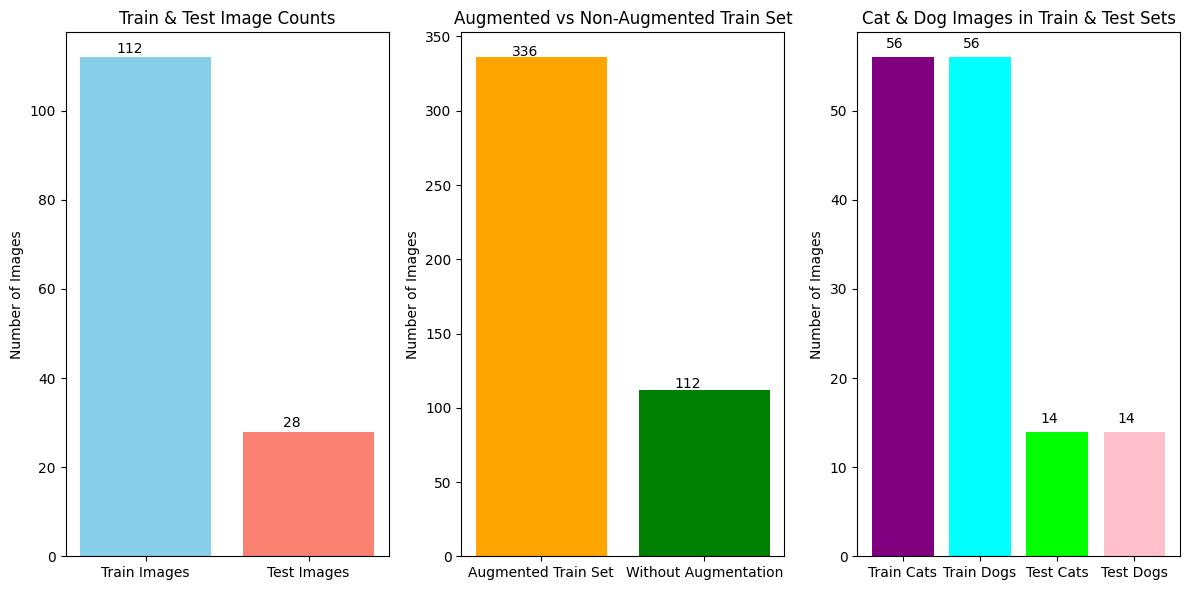

In [39]:
import matplotlib.pyplot as plt

# Example counts (replace with your actual data)
train_images = init_train_dogs + init_train_cats
test_images = test_dogs+test_cat
augmented_train_images = train_dogs + train_cat
non_augmented_train_images = train_images
train_cats = init_train_cats
train_dogs = init_train_dogs
test_cats = test_cat
test_dogs = test_dogs

# Data for plots
categories = ['Train Images', 'Test Images']
image_counts = [train_images, test_images]

augmentation_categories = ['Augmented Train Set', 'Without Augmentation']
augmentation_counts = [augmented_train_images, non_augmented_train_images]

cat_dog_labels = ['Train Cats', 'Train Dogs', 'Test Cats', 'Test Dogs']
cat_dog_counts = [train_cats, train_dogs, test_cats, test_dogs]

# Plot 1: Train & Test Image Counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
bars1 = plt.bar(categories, image_counts, color=['skyblue', 'salmon'])
plt.title('Train & Test Image Counts')
plt.ylabel('Number of Images')
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 1, f'{yval}', ha='center')

# Plot 2: Augmented vs Non-Augmented Train Set
plt.subplot(1, 3, 2)
bars2 = plt.bar(augmentation_categories, augmentation_counts, color=['orange', 'green'])
plt.title('Augmented vs Non-Augmented Train Set')
plt.ylabel('Number of Images')
for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 1, f'{yval}', ha='center')

# Plot 3: Cat & Dog Images in Train and Test Sets
plt.subplot(1, 3, 3)
bars3 = plt.bar(cat_dog_labels, cat_dog_counts, color=['purple', 'cyan', 'lime', 'pink'])
plt.title('Cat & Dog Images in Train & Test Sets')
plt.ylabel('Number of Images')
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, yval + 1, f'{yval}', ha='center')

plt.tight_layout()
plt.show()

## Task 2 

In [ ]:
%pip install transformers
%pip install torch
%pip install datasets

In [35]:

from transformers import AutoImageProcessor, ResNetForImageClassification
import torch
from datasets import load_dataset

image = Image.open("./data/final_train/dogs/dog_536_aug_0.jpg")

processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])


Labrador retriever


In [1]:
%pip install torchvision

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
   ---------------------------------------- 1.6/1.6 MB 9.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from transformers import ResNetForImageClassification, ResNetConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

d:\clg_stuff\STT assignments\STTAssignment5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Setting the random seeds for debubing
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

train_dir_non_aug = "./data/train"
train_dir_aug = "./data/final_train"
test_dir = "./data/test"


In [43]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


# Creating datasets using ImageFolder.
train_dataset_non_aug = datasets.ImageFolder(train_dir_non_aug, transform=train_transform)
train_dataset_aug = datasets.ImageFolder(train_dir_aug, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=train_transform)

# Creating DataLoaders with batch size 32.
batch_size = 32
train_loader_non_aug = DataLoader(train_dataset_non_aug, batch_size=batch_size, shuffle=True, num_workers=4)
train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Determine the number of classes (for example, cats and dogs -> 2).
num_classes = len(train_dataset_non_aug.classes)
print("Number of classes:", num_classes)

Number of classes: 2


Note: Initial weights of the model should be the same when training with both datasets.

- Choose (microsoft/resnet-50)model from the hugging face and initialize its new weights.

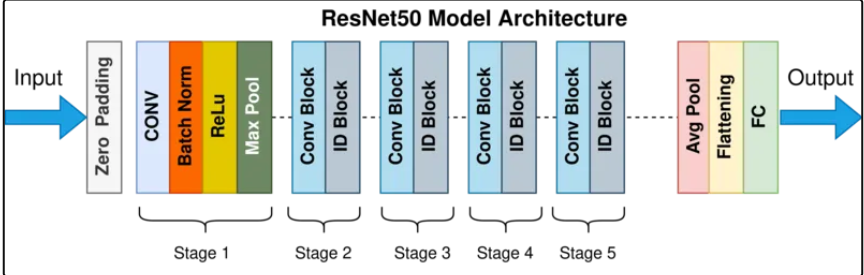
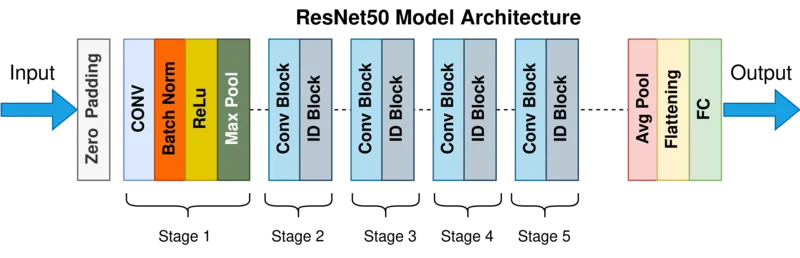

In [44]:
# Get the configuration from the Hugging Face hub.
config = ResNetConfig.from_pretrained("microsoft/resnet-50", num_labels=num_classes)

# Initialize a model with new (random) weights.
model_init = ResNetForImageClassification(config)
# Save the initial state dict.
initial_state_dict = copy.deepcopy(model_init.state_dict())

# Create two separate model instances and load the same initial weights.
model_non_aug = ResNetForImageClassification(config)
model_non_aug.load_state_dict(copy.deepcopy(initial_state_dict))

model_aug = ResNetForImageClassification(config)
model_aug.load_state_dict(copy.deepcopy(initial_state_dict))

# Move models to device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_non_aug.to(device)
model_aug.to(device)

ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBottleNeckLayer(
              (shortcut): ResNetShortCut(
                (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64

In [45]:
for param in model_non_aug.parameters():
    print(param.data)

total_params = sum(p.numel() for p in model_non_aug.parameters())
print(f"Total number of parameters: {total_params}")

tensor([[[[ 0.0036, -0.0418, -0.0319,  ...,  0.0311,  0.0086, -0.0234],
          [ 0.0042,  0.0126, -0.0085,  ...,  0.0499, -0.0033,  0.0145],
          [-0.0355,  0.0021,  0.0029,  ..., -0.0062,  0.0226,  0.0211],
          ...,
          [ 0.0208, -0.0382,  0.0200,  ...,  0.0144, -0.0085,  0.0190],
          [-0.0303, -0.0111,  0.0199,  ..., -0.0037,  0.0104,  0.0262],
          [ 0.0451,  0.0168,  0.0041,  ...,  0.0296,  0.0191, -0.0025]],

         [[-0.0294,  0.0189, -0.0099,  ..., -0.0251, -0.0004, -0.0308],
          [-0.0187,  0.0165, -0.0339,  ...,  0.0368,  0.0065, -0.0035],
          [-0.0148, -0.0256, -0.0048,  ...,  0.0219,  0.0005, -0.0264],
          ...,
          [-0.0175, -0.0048, -0.0164,  ...,  0.0098,  0.0164,  0.0253],
          [-0.0159, -0.0283, -0.0125,  ...,  0.0116, -0.0167,  0.0157],
          [ 0.0651,  0.0349,  0.0053,  ...,  0.0035, -0.0041,  0.0293]],

         [[ 0.0360,  0.0138,  0.0315,  ...,  0.0204, -0.0196, -0.0365],
          [ 0.0238,  0.0006, -

In [52]:
for name, param in model_non_aug.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")

Layer: resnet.embedder.embedder.convolution.weight | Size: torch.Size([64, 3, 7, 7]) | Requires Grad: True
Layer: resnet.embedder.embedder.normalization.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.embedder.embedder.normalization.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Size: torch.Size([256, 64, 1, 1]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.weight | Size: torch.Size([256]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.bias | Size: torch.Size([256]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.convolution.weight | Size: torch.Size([64, 64, 1, 1]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.bias | Size: torch.Size([64]) | R

In [51]:
for name, param in model_aug.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Requires Grad: {param.requires_grad}")

Layer: resnet.embedder.embedder.convolution.weight | Size: torch.Size([64, 3, 7, 7]) | Requires Grad: True
Layer: resnet.embedder.embedder.normalization.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.embedder.embedder.normalization.bias | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.convolution.weight | Size: torch.Size([256, 64, 1, 1]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.weight | Size: torch.Size([256]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.shortcut.normalization.bias | Size: torch.Size([256]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.convolution.weight | Size: torch.Size([64, 64, 1, 1]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.weight | Size: torch.Size([64]) | Requires Grad: True
Layer: resnet.encoder.stages.0.layers.0.layer.0.normalization.bias | Size: torch.Size([64]) | R

In [46]:
for param in model_aug.parameters():
    print(param.data)

total_params = sum(p.numel() for p in model_aug.parameters())
print(f"Total number of parameters: {total_params}")

tensor([[[[ 0.0036, -0.0418, -0.0319,  ...,  0.0311,  0.0086, -0.0234],
          [ 0.0042,  0.0126, -0.0085,  ...,  0.0499, -0.0033,  0.0145],
          [-0.0355,  0.0021,  0.0029,  ..., -0.0062,  0.0226,  0.0211],
          ...,
          [ 0.0208, -0.0382,  0.0200,  ...,  0.0144, -0.0085,  0.0190],
          [-0.0303, -0.0111,  0.0199,  ..., -0.0037,  0.0104,  0.0262],
          [ 0.0451,  0.0168,  0.0041,  ...,  0.0296,  0.0191, -0.0025]],

         [[-0.0294,  0.0189, -0.0099,  ..., -0.0251, -0.0004, -0.0308],
          [-0.0187,  0.0165, -0.0339,  ...,  0.0368,  0.0065, -0.0035],
          [-0.0148, -0.0256, -0.0048,  ...,  0.0219,  0.0005, -0.0264],
          ...,
          [-0.0175, -0.0048, -0.0164,  ...,  0.0098,  0.0164,  0.0253],
          [-0.0159, -0.0283, -0.0125,  ...,  0.0116, -0.0167,  0.0157],
          [ 0.0651,  0.0349,  0.0053,  ...,  0.0035, -0.0041,  0.0293]],

         [[ 0.0360,  0.0138,  0.0315,  ...,  0.0204, -0.0196, -0.0365],
          [ 0.0238,  0.0006, -

Train model(created in the above point) on a downloaded dataset, without augmentation.

Train model(created in the above point) on a downloaded dataset, without augmentation.

Train model(created in the first point) on a downloaded dataset with augmentation.
Get the precision, recall, F1 score, and accuracy of both the models on the test set.


In [47]:
criterion = nn.CrossEntropyLoss()
optimizer_non_aug = optim.Adam(model_non_aug.parameters(), lr=1e-4)
optimizer_aug = optim.Adam(model_aug.parameters(), lr=1e-4)

num_epochs = 10



def train_model(model, optimizer, dataloader, train_loss):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        # For Hugging Face image models, the output is typically a ModelOutput object.
        outputs = model(images).logits  # logits shape: [batch_size, num_labels]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    train_loss.append(epoch_loss)
    return epoch_loss

def evaluate_model(model, dataloader, test_loss, test_accuracy, test_precision, test_recall, test_f1):
    model.eval()
    all_preds = []
    all_labels = []
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    test_loss.append(epoch_loss)
    accuracy = accuracy_score(all_labels, all_preds)
    test_accuracy.append(accuracy)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_precision.append(precision)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_recall.append(recall)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    test_f1.append(f1)
    return accuracy, precision, recall, f1


print("----- Training model on non-augmented data -----")
train_loss = []
test_loss = []
test_accuracy = []
test_precision = [] 
test_recall = []
test_f1 = []
for epoch in range(num_epochs):
    loss = train_model(model_non_aug, optimizer_non_aug, train_loader_non_aug, train_loss)
    print(f"[Non-Aug] Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
    acc_non_aug, prec_non_aug, rec_non_aug, f1_non_aug = evaluate_model(model_non_aug, test_loader, test_loss, test_accuracy, test_precision, test_recall, test_f1)

print("\nNon-Augmented Model Metrics on Test Set:")
print(f"Accuracy:  {acc_non_aug:.4f}")
print(f"Precision: {prec_non_aug:.4f}")
print(f"Recall:    {rec_non_aug:.4f}")
print(f"F1 Score:  {f1_non_aug:.4f}")

print("\n----- Training model on augmented data -----")
train_loss_aug = []
test_loss_aug = []
test_accuracy_aug = []
test_precision_aug = [] 
test_recall_aug = []
test_f1_aug = []
for epoch in range(num_epochs):
    loss = train_model(model_aug, optimizer_aug, train_loader_aug, train_loss_aug)
    print(f"[Augmented] Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}")
    acc_aug, prec_aug, rec_aug, f1_aug = evaluate_model(model_aug, test_loader, test_loss_aug, test_accuracy_aug, test_precision_aug, test_recall_aug, test_f1_aug)

print("\nAugmented Model Metrics on Test Set:")
print(f"Accuracy:  {acc_aug:.4f}")
print(f"Precision: {prec_aug:.4f}")
print(f"Recall:    {rec_aug:.4f}")
print(f"F1 Score:  {f1_aug:.4f}")


----- Training model on non-augmented data -----
[Non-Aug] Epoch 1/10, Loss: 1.0629
[Non-Aug] Epoch 2/10, Loss: 0.9497
[Non-Aug] Epoch 3/10, Loss: 0.8087
[Non-Aug] Epoch 4/10, Loss: 0.6591
[Non-Aug] Epoch 5/10, Loss: 0.7224
[Non-Aug] Epoch 6/10, Loss: 0.6450
[Non-Aug] Epoch 7/10, Loss: 0.6476
[Non-Aug] Epoch 8/10, Loss: 0.6140
[Non-Aug] Epoch 9/10, Loss: 0.5877
[Non-Aug] Epoch 10/10, Loss: 0.5584

Non-Augmented Model Metrics on Test Set:
Accuracy:  0.4643
Precision: 0.4067
Recall:    0.4643
F1 Score:  0.3665

----- Training model on augmented data -----
[Augmented] Epoch 1/10, Loss: 0.7963
[Augmented] Epoch 2/10, Loss: 0.7329
[Augmented] Epoch 3/10, Loss: 0.6766
[Augmented] Epoch 4/10, Loss: 0.6792
[Augmented] Epoch 5/10, Loss: 0.6050
[Augmented] Epoch 6/10, Loss: 0.6248
[Augmented] Epoch 7/10, Loss: 0.5579
[Augmented] Epoch 8/10, Loss: 0.5110
[Augmented] Epoch 9/10, Loss: 0.5177
[Augmented] Epoch 10/10, Loss: 0.4334

Augmented Model Metrics on Test Set:
Accuracy:  0.5000
Precision: 0.

In [9]:
%pip install matplotlib

  Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-win_amd64.whl.metadata (103 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.0-cp312-cp312-win_amd64.whl (8.0 MB)
Using cached contourpy-1.3.1-cp312-cp312-win_amd64.whl (220 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp312-cp312-win_amd64.whl (2.2 MB)
Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl (71 kB)
Using cached pyparsing-3.2.1-py3-none-any.whl (107 kB)
Note: you may need to restart the kernel to use updated packages.


In [49]:
test_loss_aug

[0.7337399125099182,
 0.718163013458252,
 0.7120223045349121,
 0.8274431228637695,
 0.9512089490890503,
 1.0660523176193237,
 0.9666709303855896,
 1.1007816791534424,
 1.8945701122283936,
 1.3013900518417358]

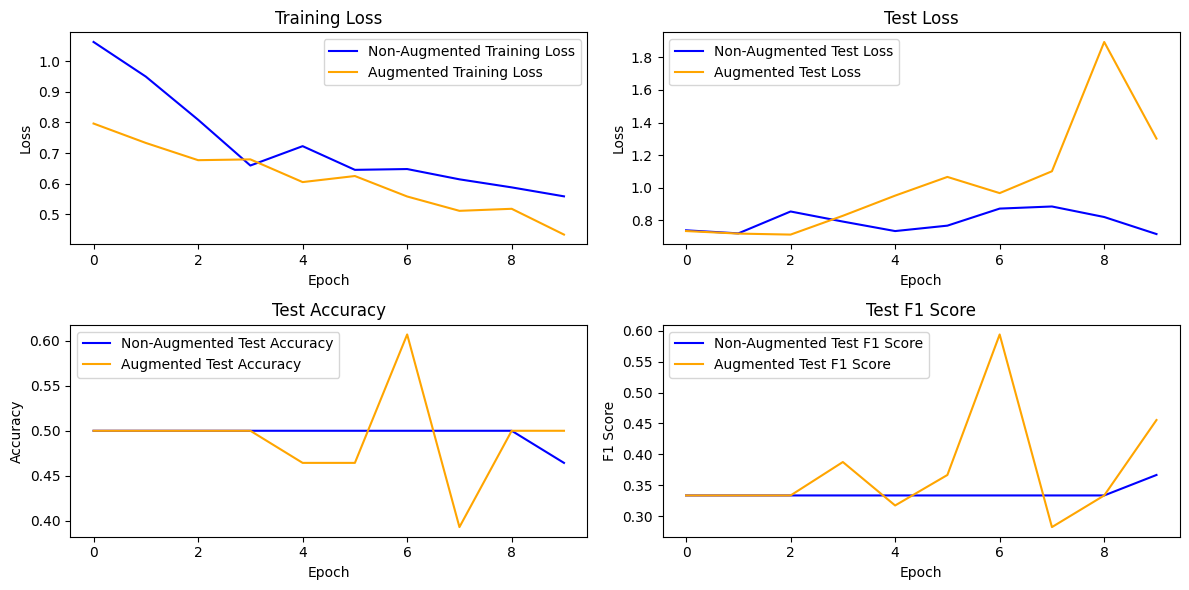

In [50]:
# plotting graph for metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


# Plotting the training loss
plt.subplot(2, 2, 1)
plt.plot(train_loss, label="Non-Augmented Training Loss", color="blue")
plt.plot(train_loss_aug, label="Augmented Training Loss", color="orange")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting the test loss
plt.subplot(2, 2, 2)
plt.plot(test_loss, label="Non-Augmented Test Loss", color="blue")
plt.plot(test_loss_aug, label="Augmented Test Loss", color="orange")
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plotting the test accuracy
plt.subplot(2, 2, 3)
plt.plot(test_accuracy, label="Non-Augmented Test Accuracy", color="blue")
plt.plot(test_accuracy_aug, label="Augmented Test Accuracy", color="orange")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the test F1 score
plt.subplot(2, 2, 4)
plt.plot(test_f1, label="Non-Augmented Test F1 Score", color="blue")

plt.plot(test_f1_aug, label="Augmented Test F1 Score", color="orange")
plt.title("Test F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()